Aggregating and Analyzing Events Over Time

<Figure size 1000x600 with 0 Axes>

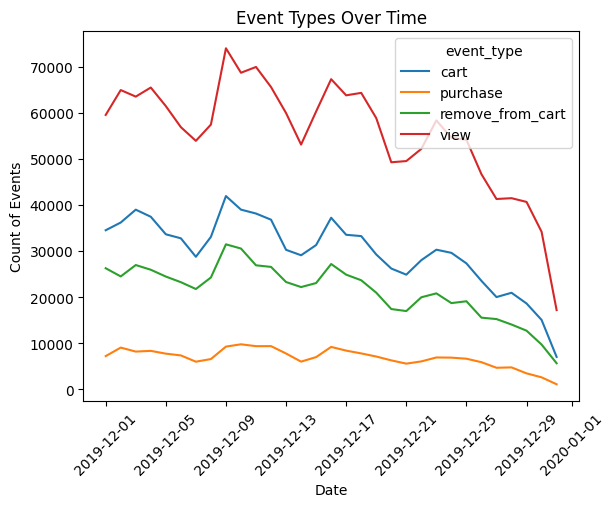

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from S3 or local file (if already saved)
df = pd.read_csv("ecommerce_events.csv")

# Convert event_time to datetime if not done already
df['event_time'] = pd.to_datetime(df['event_time'])

# Create a new column for the date (without time)
df['event_date'] = df['event_time'].dt.date

# Aggregating by event type and date
daily_events = df.groupby(['event_date', 'event_type']).size().unstack().fillna(0)

# Plotting the trends
plt.figure(figsize=(10, 6))
daily_events.plot()
plt.title('Event Types Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Events')
plt.xticks(rotation=45)
plt.show()


In [6]:
# Aggregate by user and event type, counting each event
user_behavior = df.groupby(['user_id', 'event_type']).size().unstack(fill_value=0)

# Print the columns to debug
print("Initial user_behavior columns:", user_behavior.columns)

# Ensure all expected columns are there ('cart', 'purchase', 'view'), even if some users have 0 occurrences.
expected_columns = ['cart', 'purchase', 'view']
for col in expected_columns:
    if col not in user_behavior.columns:
        user_behavior[col] = 0

# Print the updated columns to check
print("Updated user_behavior columns:", user_behavior.columns)

# Rename the columns dynamically based on the presence
# Get the current columns
current_columns = user_behavior.columns.tolist()

# Generate new names dynamically
new_names = [f"{col}_count" for col in current_columns]

# Rename the columns
user_behavior.columns = new_names

# Calculate total events per user
user_behavior['total_events'] = user_behavior.sum(axis=1)

# Check the result
print(user_behavior.head())


Initial user_behavior columns: Index(['cart', 'purchase', 'remove_from_cart', 'view'], dtype='object', name='event_type')
Updated user_behavior columns: Index(['cart', 'purchase', 'remove_from_cart', 'view'], dtype='object', name='event_type')
         cart_count  purchase_count  remove_from_cart_count  view_count  \
user_id                                                                   
1180452           0               0                       0           1   
2963072           7               0                       0          17   
4661182           2               0                       2           3   
4891613           0               0                       0           1   
6217356           0               0                       0           1   

         total_events  
user_id                
1180452             1  
2963072            24  
4661182             7  
4891613             1  
6217356             1  


Objective: Understand the average session length and the number of events per session.

In [7]:
# Calculate session lengths
session_length = df.groupby('user_session')['event_time'].agg(['min', 'max'])
session_length['session_duration'] = (session_length['max'] - session_length['min']).dt.total_seconds() / 60  # in minutes

# Count the number of events per session
events_per_session = df.groupby('user_session')['event_type'].count()

# Combine results into a single DataFrame
session_analysis = pd.DataFrame({
    'session_duration': session_length['session_duration'],
    'events_per_session': events_per_session
})

# Display summary statistics
print("Session Analysis Summary:")
print(session_analysis.describe())


Session Analysis Summary:
       session_duration  events_per_session
count     839812.000000       839812.000000
mean          59.281888            4.206307
std          930.363251           12.744874
min            0.000000            1.000000
25%            0.000000            1.000000
50%            0.000000            1.000000
75%            1.350000            2.000000
max        43696.466667         1393.000000


Event Type Distribution

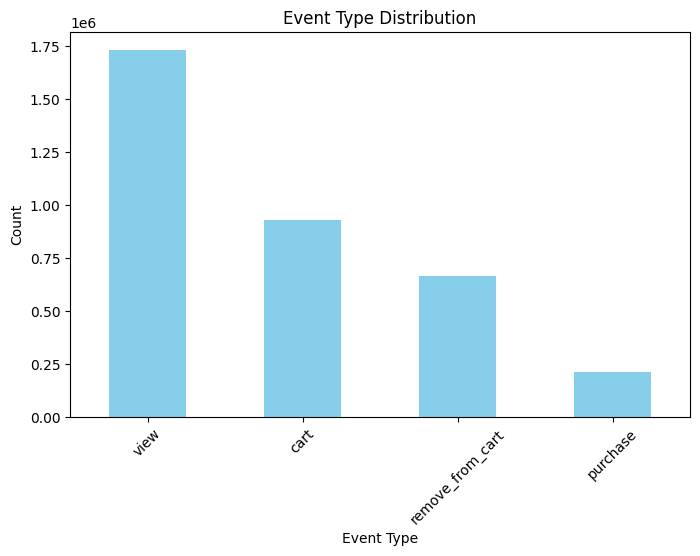

In [8]:
import matplotlib.pyplot as plt

event_counts = df['event_type'].value_counts()

plt.figure(figsize=(8, 5))
event_counts.plot(kind='bar', color='skyblue')
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Product Interaction Analysis

In [10]:
# Create a DataFrame to count event types for each product
product_event_counts = df.groupby(['product_id', 'event_type']).size().unstack(fill_value=0)

# Display the interaction counts for each product
print("Product Interaction Counts:")
print(product_event_counts)

# You can rename the columns for better clarity if needed
product_event_counts.columns = [f"{event}_count" for event in product_event_counts.columns]

# Get top 10 products based on purchase count
top_products = product_event_counts.sort_values(by='purchase_count', ascending=False).head(10)

print("Top 10 Products Based on Purchase Count:")
print(top_products)


Product Interaction Counts:
event_type  cart  purchase  remove_from_cart  view
product_id                                        
3752           0         0                 0     8
3762         251        68               112   568
3763          18         4                15   128
3771           0         0                 0     5
3774          79        24                46   232
...          ...       ...               ...   ...
5917173        0         0                 0     2
5917174        0         0                 0     2
5917175        1         0                 2     7
5917177        0         0                 0     5
5917178        0         0                 0    40

[44624 rows x 4 columns]
Top 10 Products Based on Purchase Count:
            cart_count  purchase_count  remove_from_cart_count  view_count
product_id                                                                
5809910           6513            1659                    2634       24419
5854897          

Task for interns to create product Info table and join with this and name top 10mm products

In [11]:
# Create user segments based on total events and purchase counts
user_segments = user_behavior.copy()
user_segments['user_type'] = pd.cut(user_segments['purchase_count'], bins=[-1, 0, 5, 20, float('inf')],
                                     labels=['Casual', 'Occasional', 'Frequent', 'Loyal'])

print("User Segmentation:")
print(user_segments['user_type'].value_counts())


User Segmentation:
user_type
Casual        344541
Occasional     13289
Frequent       10412
Loyal           1912
Name: count, dtype: int64


Homework: Ask interns to explore other interesting patterns in the dataset, such as:

What time of day has the most events?
Are there any seasonal trends in product purchases?
Analyze the impact of product categories on purchasing behavior.
Report Presentation: Have interns prepare a short presentation summarizing their findings from the analysis and share their insights with the group.